# Day 8 Analysis

For Day 8, let's look at the relationship between air yards and fantasy points for receivers and see who might be due for a positive or negative regression to the mean.

## Set Up

In [7]:
import pandas as pd
from os import path
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Air Yards vs. Fantasy Points
Let's get air yards and fantasy points scored for receivers going back to 1999. We should see a positive relationship – as air yards increase, fantasy points scored should increase as well.

In [29]:
query = """
SELECT
    player_id,
    player_display_name AS player_name,
    season,
    week,
    receptions,
    targets,
    receiving_yards AS yds,
    receiving_tds AS tds,
    receiving_air_yards AS air_yds,
    receiving_yards_after_catch AS yac,
    ROUND(target_share,3) AS tgt_share,
    ROUND(air_yards_share,3) AS air_yds_share,
    ROUND(fantasy_points,2) AS fantasy_pts,
    ROUND(fantasy_points_ppr,2) AS fantasy_pts_ppr
FROM weekly 
WHERE position = 'WR'
    AND season_type = 'REG'
"""

df_all = pd.read_sql(query, conn)

print(df_all.shape)
df_all.head()

(43959, 14)


,player_id,player_name,season,week,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
0,00-0000145,Derrick Alexander,1999,1,6,10,154.0,1,0.0,0.0,0.244,0.0,21.4,27.4
1,00-0000145,Derrick Alexander,1999,2,6,7,117.0,0,0.0,0.0,0.412,0.0,11.7,17.7
2,00-0000145,Derrick Alexander,1999,3,3,6,69.0,0,0.0,0.0,0.207,0.0,6.9,9.9
3,00-0000145,Derrick Alexander,1999,4,1,7,14.0,0,0.0,0.0,0.194,0.0,1.4,2.4
4,00-0000145,Derrick Alexander,1999,5,2,5,25.0,0,0.0,0.0,0.200,0.0,2.5,4.5


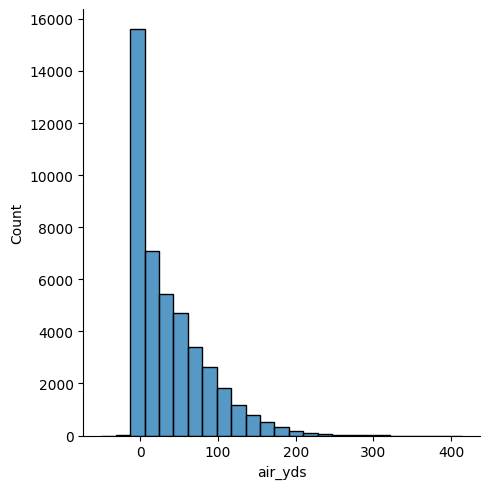

In [47]:
# Check distribution
sns.displot(
    x="air_yds",
    data=df_all,
    kind="hist",
    bins = 25
)

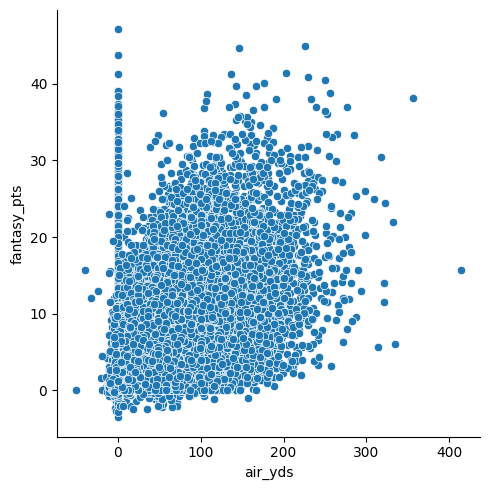

In [76]:
sns.relplot(
    x="air_yds",
    y="fantasy_pts",
    data=df_all
)

There are a lot of cases where air yards = 0. This seems to be data error based on the clearly positive relationship observed. I'll remove these cases and calculate the Pearson Correlation Coefficient to confirm.

In [48]:
# Remove instances where air_yards = 0
df_clean = df_all[df_all['air_yds'] != 0]

In [49]:
print(f"Correlation Coefficient: {df_clean['air_yds'].corr(df_clean['fantasy_pts'])}")

Correlation Coefficient: 0.5784392747420832


/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_50613/1368989657.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_avg = df_clean.groupby('player_id').mean().round(2)


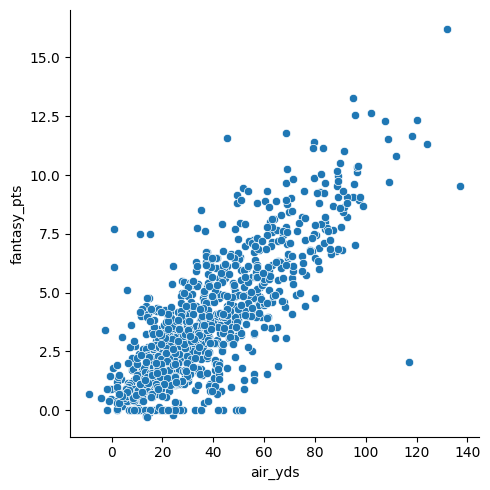

In [73]:
# Check average
df_avg = df_clean.groupby('player_id').mean().round(2)

sns.relplot(
    x="air_yds",
    y="fantasy_pts",
    data=df_avg
)

In [74]:
col_order = ['player_name', 'season', 'week', 'receptions', 'targets', 'yds', 'tds',
       'air_yds', 'yac', 'tgt_share', 'air_yds_share', 'fantasy_pts',
       'fantasy_pts_ppr']

df_avg = df_avg.sort_values('fantasy_pts', ascending=False) \
    .reset_index() \
    .merge(
        df_clean[['player_id','player_name']].drop_duplicates(), 
        how='left'
    )[col_order]

df_avg.head(10)


,player_name,season,week,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
0,Kristian Wilkerson,2021.00,17.00,4.00,8.00,42.00,2.00,132.00,5.00,0.24,0.53,16.20,20.20
1,Ja'Marr Chase,2021.29,7.88,5.33,8.42,85.83,0.79,95.04,38.50,0.24,0.37,13.26,18.60
2,Justin Jefferson,2020.78,8.48,6.20,9.07,94.20,0.48,101.92,31.68,0.28,0.42,12.63,18.83
3,Tyreek Hill,2018.79,8.72,5.54,8.08,76.68,0.59,95.83,27.29,0.23,0.34,12.56,18.10
4,Calvin Johnson,2010.97,9.14,5.41,8.90,86.07,0.61,120.21,24.36,0.25,0.42,12.35,17.76
5,Antonio Brown,2014.92,9.06,6.44,9.76,85.35,0.58,107.44,31.00,0.27,0.33,12.29,18.73
6,Cooper Kupp,2019.43,8.08,6.45,8.84,80.56,0.58,68.60,37.90,0.25,0.26,11.77,18.22
7,Julio Jones,2016.08,8.46,6.02,9.39,91.34,0.42,117.99,29.46,0.25,0.38,11.67,17.70
8,Deebo Samuel,2020.34,8.39,4.52,6.82,67.84,0.27,45.25,44.07,0.23,0.20,11.58,16.10
9,Odell Beckham,2017.41,8.58,5.53,9.17,76.74,0.58,108.83,26.18,0.26,0.37,11.54,17.07


In [75]:
df_avg.sort_values('yac', ascending=False)

,player_name,season,week,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
8,Deebo Samuel,2020.34,8.39,4.52,6.82,67.84,0.27,45.25,44.07,0.23,0.20,11.58,16.10
1,Ja'Marr Chase,2021.29,7.88,5.33,8.42,85.83,0.79,95.04,38.50,0.24,0.37,13.26,18.60
6,Cooper Kupp,2019.43,8.08,6.45,8.84,80.56,0.58,68.60,37.90,0.25,0.26,11.77,18.22
283,Rondale Moore,2021.28,7.33,4.17,5.17,37.22,0.11,13.78,34.89,0.15,0.05,4.76,8.93
52,Wes Welker,2010.14,9.32,6.12,7.88,66.36,0.35,49.20,32.95,0.25,0.20,8.82,14.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,Kerry Meier,2011.00,7.00,0.00,1.00,0.00,0.00,10.00,0.00,0.03,0.04,0.00,0.00
894,Julian Talley,2013.00,17.00,0.00,2.00,0.00,0.00,13.00,0.00,0.06,0.06,0.00,0.00
895,Isaac Fruechte,2016.00,17.00,0.00,1.00,0.00,0.00,35.00,0.00,0.03,0.18,0.00,0.00
927,Nathan Palmer,2012.00,7.33,0.33,1.33,-1.33,0.00,14.67,-0.33,0.03,0.02,-0.13,0.20


## Air Yards vs. Fantasy Points: 2022

In [77]:
f_2022 = df_clean['season'] == 2022

df_2022 = df_clean[f_2022].groupby('player_id').mean().round(2)

df_2022 = df_2022.sort_values('fantasy_pts', ascending=False) \
    .reset_index() \
    .merge(
        df_clean[['player_id','player_name']].drop_duplicates(), 
        how='left'
    )[col_order]

df_2022.head(10)

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_50613/1202067746.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_2022 = df_clean[f_2022].groupby('player_id').mean().round(2)


,player_name,season,week,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
0,Stefon Diggs,2022.0,4.14,7.86,10.43,109.14,1.00,110.29,35.71,0.29,0.37,16.91,24.77
1,DeAndre Hopkins,2022.0,7.50,11.00,13.50,131.00,0.50,146.50,16.00,0.39,0.58,16.10,27.10
2,Cooper Kupp,2022.0,4.14,9.14,12.00,98.00,0.71,88.71,48.86,0.32,0.41,15.39,24.53
3,Tyreek Hill,2022.0,4.50,8.62,11.50,120.12,0.25,132.38,37.25,0.32,0.38,13.82,22.45
4,Justin Jefferson,2022.0,4.14,7.43,10.14,107.43,0.29,82.29,47.43,0.29,0.42,13.77,21.20
5,A.J. Brown,2022.0,4.14,5.57,9.14,94.14,0.71,98.57,35.43,0.32,0.47,13.70,19.27
6,Ja'Marr Chase,2022.0,4.00,6.71,10.57,86.43,0.86,94.86,39.00,0.28,0.37,13.53,20.24
7,Jaylen Waddle,2022.0,4.50,5.25,7.88,90.88,0.62,82.62,35.25,0.22,0.27,12.80,18.05
8,Michael Thomas,2022.0,2.00,5.33,7.33,57.00,1.00,79.00,7.00,0.20,0.20,11.70,17.03
9,Davante Adams,2022.0,4.29,5.43,9.71,73.14,0.71,109.86,25.00,0.30,0.40,11.59,17.01


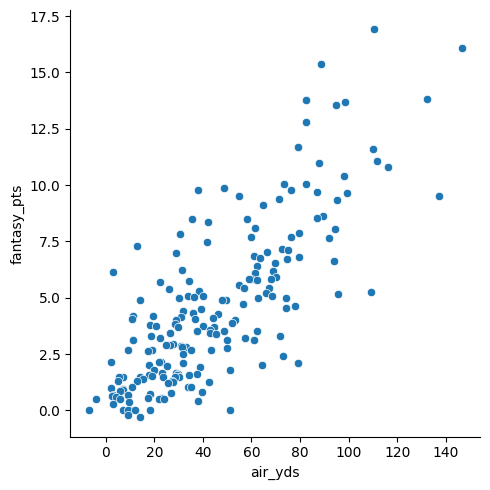

In [78]:
sns.relplot(
    x="air_yds",
    y="fantasy_pts",
    data=df_2022
)

In [86]:
col_order = ['player_name',
       'air_yds', 'fantasy_pts',
       'fantasy_pts_ppr']

df_2022.sort_values('air_yds', ascending=False)[col_order].head(10)

,player_name,air_yds,fantasy_pts,fantasy_pts_ppr
1,DeAndre Hopkins,146.50,16.10,27.10
21,Chris Olave,137.14,9.53,14.81
3,Tyreek Hill,132.38,13.82,22.45
12,Mike Evans,116.43,10.81,16.39
10,Marquise Brown,111.50,11.08,18.25
0,Stefon Diggs,110.29,16.91,24.77
9,Davante Adams,109.86,11.59,17.01
67,D.J. Chark,109.33,5.27,7.60
20,Mike Williams,99.29,9.64,14.93
5,A.J. Brown,98.57,13.70,19.27
